In [79]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import Holt
from matplotlib import pyplot as plt

df = pd.read_csv("IBM.csv")
df.set_index("Date", inplace=True)
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-03,7.291268,7.355003,7.291268,7.355003,1.641101,305955
1962-01-04,7.355003,7.355003,7.278521,7.281708,1.624746,274575
1962-01-05,7.272148,7.272148,7.125558,7.138305,1.592751,384405
1962-01-08,7.131931,7.131931,6.947100,7.004461,1.562885,572685
1962-01-09,7.036329,7.176546,7.036329,7.087317,1.581373,517770
1962-01-10,7.100064,7.131931,7.100064,7.100064,1.584218,313800
1962-01-11,7.119184,7.176546,7.119184,7.176546,1.601283,337335
1962-01-12,7.189293,7.240280,7.189293,7.189293,1.604128,462855
1962-01-15,7.214786,7.237094,7.214786,7.221160,1.611236,266730


In [80]:
filtered_df = df[datetime(1998, 10, 8) : datetime(1998, 11, 29)]["Close"]

filtered_df = filtered_df.resample("B").ffill()
filtered_df.describe()

ncut = int(0.8 * filtered_df.shape[0])

train_data = filtered_df.iloc[:ncut]
test_data = filtered_df.iloc[ncut:]


In [81]:
def level_eq(alpha, y, l, b):
    return alpha * y + (1 - alpha) * (l + b)


def trend_eq(beta, l_t, l_t1, b):
    return beta * (l_t - l_t1) + (1 - beta) * b


def custom_holt(values, alpha, beta):
    results = [values[0]]
    trend = [values[1] - values[0]]
    level = [values[0]]

    for idx, y in enumerate(values):
        if idx + 1 == len(values):
            break
        level.append(level_eq(alpha, y, level[idx], trend[idx]))
        trend.append(trend_eq(beta, level[idx + 1], level[idx], trend[idx]))
        results.append(level[idx + 1] + trend[idx + 1])

    return results



In [82]:
values = filtered_df.values
results = []

for alpha in [x / 100 for x in range(100)]:
    for beta in [x / 100 for x in range(100)]:
        holt = custom_holt(values, alpha, beta)
        mse = mean_squared_error(values, holt)
        results.append((mse, alpha, beta))

best = min(results, key=lambda x: x[0])
print(best)


(1.0719287168213876, 0.71, 0.22)


In [83]:
fit_holt = Holt(filtered_df).fit()
print(f"Holt's alpha: {fit_holt.params['smoothing_level']}, beta: {fit_holt.params['smoothing_trend']}")

Holt's alpha: 0.6003589579251706, beta: 6.76591786219046e-11


/home/luq/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


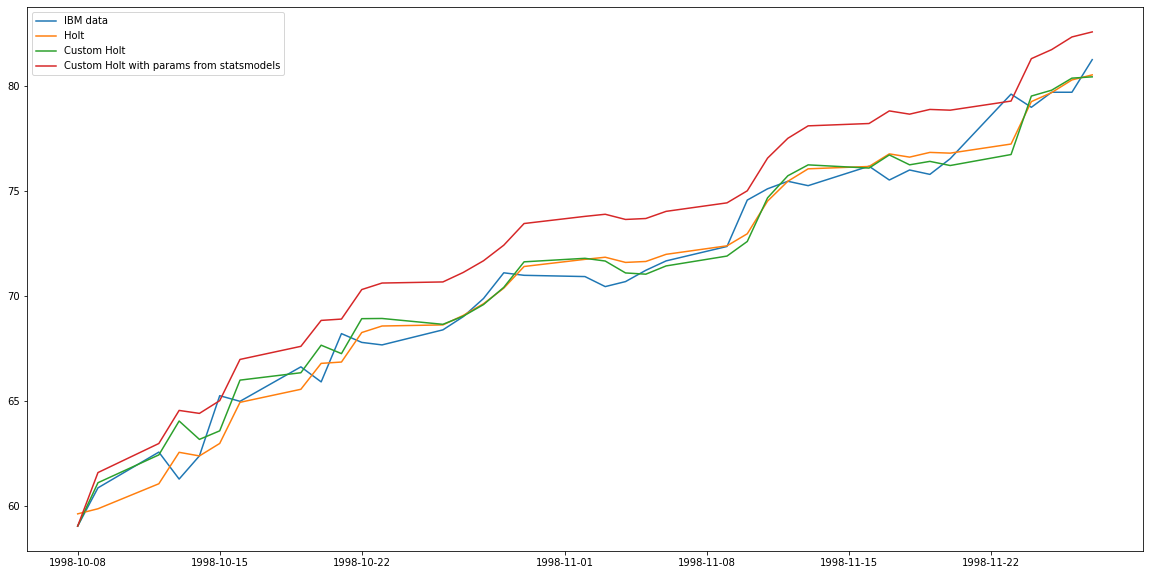

In [84]:
plt.figure(figsize=(20,10))


plt.plot(filtered_df)
plt.plot(fit_holt.fittedvalues)
plt.plot(filtered_df.index, custom_holt(values, best[1], best[2]))
plt.plot(filtered_df.index, custom_holt(values, 0.6003589579251706, 6.76591786219046e-11))
plt.legend(["IBM data", "Holt", "Custom Holt", "Custom Holt with params from statsmodels"])
